# Population analysis

# Loading packages

In [1]:
import pandas as pd  # Pandas for data analysis.
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
from IPython.display import display # Pretty display of data frames.

from sklearn import base
from sklearn.feature_selection import chi2, f_classif

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

# Loading data

In [3]:
experiments = ['exp{}'.format(j) for j in [1,2,3]]
samples = ['Sample{}'.format(j) for j in [1,2,3,4,5,6]]
datasets = [(experiment, sample) for experiment in experiments for sample in samples]
datasets

[('exp1', 'Sample1'),
 ('exp1', 'Sample2'),
 ('exp1', 'Sample3'),
 ('exp1', 'Sample4'),
 ('exp1', 'Sample5'),
 ('exp1', 'Sample6'),
 ('exp2', 'Sample1'),
 ('exp2', 'Sample2'),
 ('exp2', 'Sample3'),
 ('exp2', 'Sample4'),
 ('exp2', 'Sample5'),
 ('exp2', 'Sample6'),
 ('exp3', 'Sample1'),
 ('exp3', 'Sample2'),
 ('exp3', 'Sample3'),
 ('exp3', 'Sample4'),
 ('exp3', 'Sample5'),
 ('exp3', 'Sample6')]

In [4]:
JM = {}
for ds in datasets:
    fn = 'Raw/JM_10X_'+ds[0]+'_'+ds[1]+'.loom'
    JM[ds] = sc.read_loom(fn)

In [5]:
metacols =['experiment','well','clone','CD_type']

meta_df = pd.concat([JM[ds].obs[metacols] for ds in datasets])

meta_df
    

,experiment,well,clone,CD_type
CellID,,,,
exp1_AAACCTGAGCCCAATT-1,exp1,Sample1,non,unknown
exp1_AAACCTGTCCGCATAA-1,exp1,Sample1,18,CD4
exp1_AAACGGGGTTACGGAG-1,exp1,Sample1,non,unknown
exp1_AAACGGGTCGAATCCA-1,exp1,Sample1,17,CD8
exp1_AAACGGGTCTGTGCAA-1,exp1,Sample1,non,unknown
...,...,...,...,...
exp3_TTTGCGCTCTGCTTGC-1,exp3,Sample6,non,unknown
exp3_TTTGGTTTCCGCATCT-1,exp3,Sample6,40,CD4
exp3_TTTGTCAAGCGTGAGT-1,exp3,Sample6,1,CD4


# Create population dataframe

Note -- when we go from experiment 1 to experiment 2, we randomly sample cells from each of the wells in experiment 1.  The column exp1_abs contains the absolute numbers of cells in experiment 1.  The column exp1_norm multiplies these numbers, to normalize each well to a total of 1000 cells.

In [6]:
pop_df = pd.DataFrame(0,index=meta_df.clone.unique(), 
                      columns=['exp1_abs','exp1_norm','exp1_perc'] + 
                      ['exp2_Sample{}_perc'.format(j) for j in [1,2,3,4,5,6]] + 
                      ['exp2_Sample{}'.format(j) for j in [1,2,3,4,5,6]])

# First timepoint
mf = meta_df[meta_df['experiment'] == 'exp1']
well_scaler = 1000 / mf.well.value_counts() # Normalize all wells to have 1000 cells.
mf_vc = mf.value_counts(['clone','well'])
for clone,well in mf_vc.index:
    pop_df.loc[clone, 'exp1_abs'] += mf_vc[(clone,well)] 
    pop_df.loc[clone, 'exp1_norm'] += mf_vc[(clone,well)] * well_scaler[well]

pop_df['exp1_perc'] = pop_df['exp1_norm'] / pop_df['exp1_norm'].sum()
pop_df.head() # Complete at timepoint 1.

,exp1_abs,exp1_norm,exp1_perc,exp2_Sample1_perc,exp2_Sample2_perc,exp2_Sample3_perc,exp2_Sample4_perc,exp2_Sample5_perc,exp2_Sample6_perc,exp2_Sample1,exp2_Sample2,exp2_Sample3,exp2_Sample4,exp2_Sample5,exp2_Sample6
non,3183,1445.813375,0.240969,0,0,0,0,0,0,0,0,0,0,0,0
18,82,44.711014,0.007452,0,0,0,0,0,0,0,0,0,0,0,0
17,269,146.673937,0.024446,0,0,0,0,0,0,0,0,0,0,0,0
15,222,121.046892,0.020174,0,0,0,0,0,0,0,0,0,0,0,0
1,477,260.087241,0.043348,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
mf = meta_df[meta_df['experiment'] == 'exp2']
mf_vc = mf.value_counts(['clone','well'])
mf_vc
for clone,well in mf_vc.index:
    pop_df.loc[clone, 'exp2_'+well] = mf_vc[(clone,well)]
    pop_df['exp2_'+well+'_perc'] = pop_df['exp2_'+well] / pop_df['exp2_'+well].sum()

pop_df

,exp1_abs,exp1_norm,exp1_perc,exp2_Sample1_perc,exp2_Sample2_perc,exp2_Sample3_perc,exp2_Sample4_perc,exp2_Sample5_perc,exp2_Sample6_perc,exp2_Sample1,exp2_Sample2,exp2_Sample3,exp2_Sample4,exp2_Sample5,exp2_Sample6
non,3183,1445.813375,0.240969,0.520221,0.328447,0.280118,0.399672,0.387714,0.370185,283,605,379,731,1155,961
18,82,44.711014,0.007452,0.014706,0.009229,0.006652,0.028431,0.008728,0.016564,8,17,9,52,26,43
17,269,146.673937,0.024446,0.012868,0.017915,0.000000,0.019136,0.037932,0.013867,7,33,0,35,113,36
15,222,121.046892,0.020174,0.038603,0.037459,0.009608,0.010388,0.002014,0.006549,21,69,13,19,6,17
1,477,260.087241,0.043348,0.023897,0.072747,0.113821,0.064516,0.101376,0.033513,13,134,154,118,302,87
13,57,31.079607,0.005180,0.001838,0.003257,0.025129,0.007108,0.024841,0.023498,1,6,34,13,74,61
46,2,1.090513,0.000182,0.000000,0.006515,0.000000,0.000547,0.000000,0.000385,0,12,0,1,0,1
2,1180,522.817900,0.087136,0.025735,0.021173,0.023651,0.075451,0.031219,0.053544,14,39,32,138,93,139
19,309,136.907399,0.022818,0.001838,0.004343,0.002217,0.011482,0.017456,0.017334,1,8,3,21,52,45
23,263,116.526362,0.019421,0.007353,0.021716,0.000000,0.004921,0.008056,0.004237,4,40,0,9,24,11


In [8]:
mf = meta_df[meta_df['experiment'] == 'exp3']
mf_vc = mf.value_counts(['clone','well'])
mf_vc
for clone,well in mf_vc.index:
    pop_df.loc[clone, 'exp3_'+well] = mf_vc[(clone,well)]
    pop_df['exp3_'+well+'_perc'] = pop_df['exp3_'+well] / pop_df['exp3_'+well].sum()

pop_df

,exp1_abs,exp1_norm,exp1_perc,exp2_Sample1_perc,exp2_Sample2_perc,exp2_Sample3_perc,exp2_Sample4_perc,exp2_Sample5_perc,exp2_Sample6_perc,exp2_Sample1,...,exp3_Sample4,exp3_Sample4_perc,exp3_Sample2,exp3_Sample2_perc,exp3_Sample3,exp3_Sample3_perc,exp3_Sample5,exp3_Sample5_perc,exp3_Sample6,exp3_Sample6_perc
non,3183,1445.813375,0.240969,0.520221,0.328447,0.280118,0.399672,0.387714,0.370185,283,...,2023.0,0.371261,1593.0,0.411841,1144.0,0.368319,582.0,0.330870,417.0,0.396011
18,82,44.711014,0.007452,0.014706,0.009229,0.006652,0.028431,0.008728,0.016564,8,...,41.0,0.007524,8.0,0.002068,17.0,0.005473,23.0,0.013076,13.0,0.012346
17,269,146.673937,0.024446,0.012868,0.017915,0.000000,0.019136,0.037932,0.013867,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,222,121.046892,0.020174,0.038603,0.037459,0.009608,0.010388,0.002014,0.006549,21,...,62.0,0.011378,10.0,0.002585,77.0,0.024791,53.0,0.030131,22.0,0.020893
1,477,260.087241,0.043348,0.023897,0.072747,0.113821,0.064516,0.101376,0.033513,13,...,1062.0,0.194898,708.0,0.183040,516.0,0.166130,219.0,0.124503,117.0,0.111111
13,57,31.079607,0.005180,0.001838,0.003257,0.025129,0.007108,0.024841,0.023498,1,...,200.0,0.036704,142.0,0.036711,62.0,0.019961,45.0,0.025583,19.0,0.018044
46,2,1.090513,0.000182,0.000000,0.006515,0.000000,0.000547,0.000000,0.000385,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1180,522.817900,0.087136,0.025735,0.021173,0.023651,0.075451,0.031219,0.053544,14,...,599.0,0.109928,124.0,0.032058,298.0,0.095943,193.0,0.109721,121.0,0.114910
19,309,136.907399,0.022818,0.001838,0.004343,0.002217,0.011482,0.017456,0.017334,1,...,95.0,0.017434,47.0,0.012151,52.0,0.016742,42.0,0.023877,15.0,0.014245
23,263,116.526362,0.019421,0.007353,0.021716,0.000000,0.004921,0.008056,0.004237,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
pop_df.to_csv('population_changes.csv')

# Analyzing population changes from one experiment to the next.

In [10]:
afters = [experiment + '_' + sample for experiment in ['exp2','exp3'] for sample in samples]

clones = [clone for clone in pop_df.index if clone != 'non']

growth_max_df = pd.DataFrame(index = clones, columns = afters)
growth_min_df = pd.DataFrame(index = clones, columns = afters)

for clone in clones:
    c_perc = pop_df.loc[clone, 'exp1_perc']
    std = np.sqrt(1000*c_perc*(1-c_perc))
    N_low = (1000*c_perc) - 2*std # Low-end estimate from sampling
    N_low = max(N_low, 1)
    N_high = (1000*c_perc) + 2*std # High-end estimate from sampling.
    for after in afters:
        c_perc = pop_df.loc[clone, after+'_'+'perc']
        growth_min_df.loc[clone,after] = 1000*c_perc / N_high # Low estimate of growth rate
        growth_max_df.loc[clone,after] = 1000*c_perc / N_low # High estimate of growth rate
        
growth_max_df

,exp2_Sample1,exp2_Sample2,exp2_Sample3,exp2_Sample4,exp2_Sample5,exp2_Sample6,exp3_Sample1,exp3_Sample2,exp3_Sample3,exp3_Sample4,exp3_Sample5,exp3_Sample6
18,7.306887,4.585647,3.305111,14.126382,4.336548,8.230099,2.187293,1.027649,2.719498,3.738594,6.496857,6.134177
17,0.876617,1.220492,0.0,1.303662,2.584155,0.944732,NaN,NaN,NaN,NaN,NaN,NaN
15,3.421532,3.320165,0.85162,0.920746,0.178518,0.580423,0.692256,0.229147,2.1973,1.008498,2.670608,1.851802
1,0.784317,2.387605,3.735685,2.117462,3.327237,1.099922,2.964206,6.007504,5.452499,6.396686,4.086256,3.64674
13,1.838235,3.257329,25.129342,7.107709,24.840551,23.497689,26.838966,36.711479,19.961365,36.703982,25.582717,18.043685
46,0.0,6.514658,0.0,0.546747,0.0,0.385208,NaN,NaN,NaN,NaN,NaN,NaN
2,0.371367,0.305526,0.341292,1.088778,0.450491,0.772652,0.565571,0.462604,1.384486,1.586295,1.583308,1.658177
19,0.137449,0.324745,0.165793,0.858514,1.305192,1.296133,1.051189,0.908559,1.251825,1.303612,1.785357,1.065135
23,0.687628,2.030779,0.0,0.460173,0.753413,0.39626,NaN,NaN,NaN,NaN,NaN,NaN
9,0.933269,4.961219,3.752388,16.932522,14.486182,10.169607,17.01459,10.237965,24.51858,12.298797,44.160207,32.78582


In [11]:
clones = pop_df['exp1_norm'][clones].sort_values(ascending=False).index  # Sort by initial clone size.

In [12]:
growth_max_df.loc['5'].dropna(inplace=False)

exp2_Sample1    0.349645
exp2_Sample2    0.367151
exp2_Sample3    0.070291
exp2_Sample4    0.265765
exp2_Sample5    0.262492
exp2_Sample6     0.15468
Name: 5, dtype: object

In [13]:
clone = '5'

In [14]:
def gr_plot(clone):
    sns.set_style('white')
    mins = growth_min_df.loc[clone].dropna(inplace=False)
    maxs = growth_max_df.loc[clone].dropna(inplace=False)
    fig,ax = plt.subplots(1,1,figsize=(len(mins)*0.4,2))
    bot = int(np.floor(np.log10(0.001+mins.min())))
    top = int(np.ceil(np.log10(0.001+maxs.max())))
    yrange = [10**j for j in range(bot,top+1)]
    plt.yscale('symlog', linthresh=10**(bot-1))
    for j,after in enumerate(mins.index):
        if maxs[after] == 0:
            ax.plot([j,j], [0,0.0001], label=after, lw=5)
        else:
            ax.plot([j,j], [mins[after], maxs[after]], label=after, lw=5)
    ax.axhline(1.0, color='lightgray')
    ax.set_yticks([0]+yrange)
    ax.set_yticklabels([0]+yrange)
    ax.set_xticks(range(len(mins.index)))
    ax.set_xticklabels(mins.index, rotation=90)
    ax.set_title('Clone {}, {:1.2%} of Population'.format(clone, pop_df.loc[clone, 'exp1_perc']))
    plt.show()

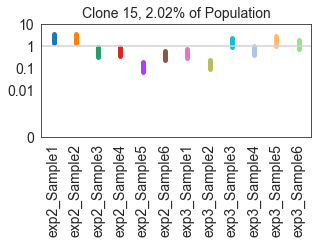

In [15]:
gr_plot('15')

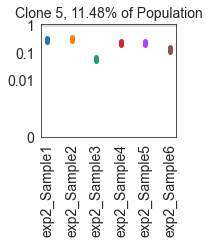

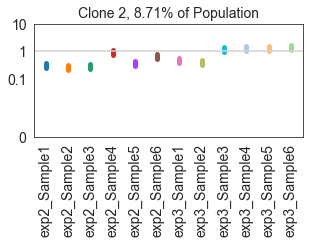

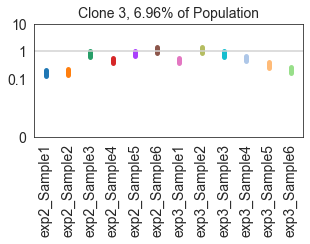

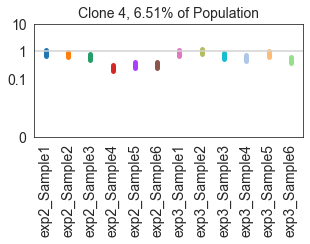

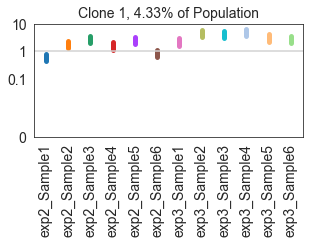

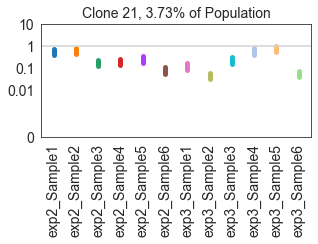

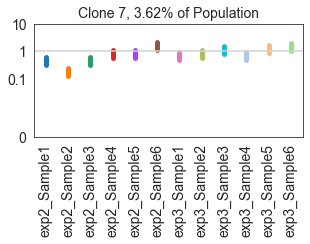

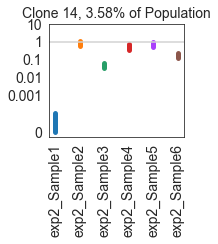

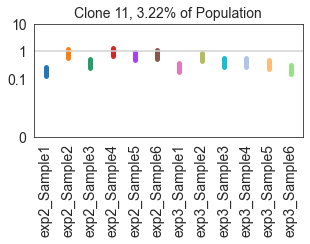

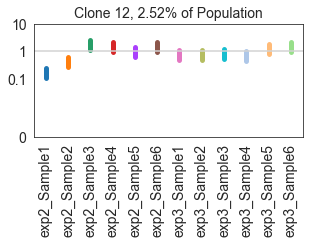

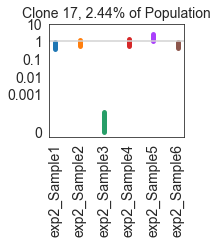

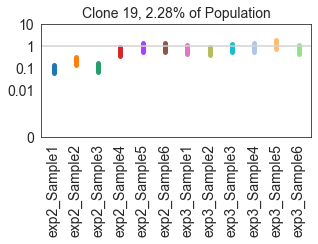

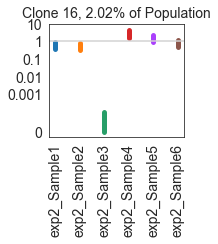

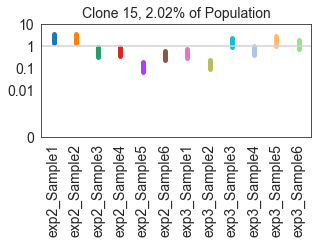

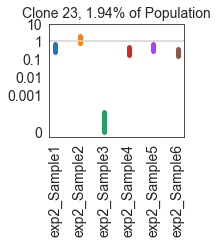

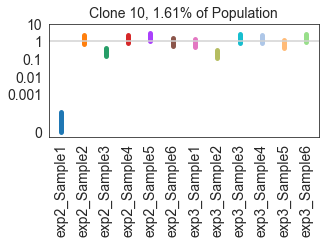

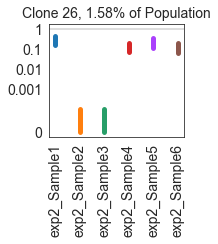

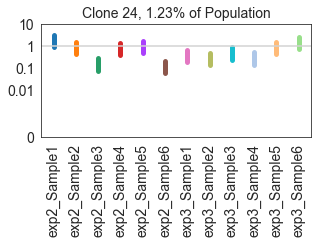

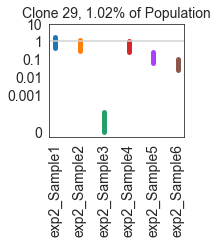

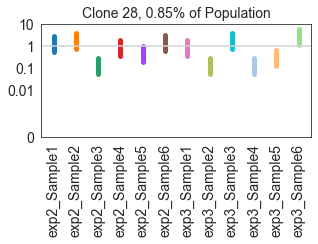

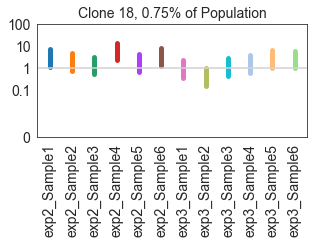

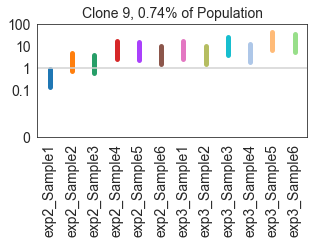

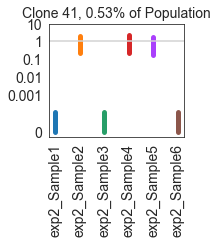

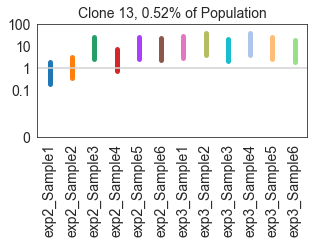

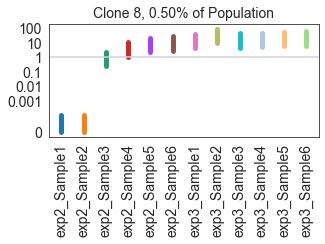

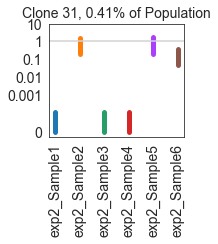

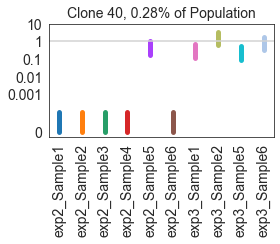

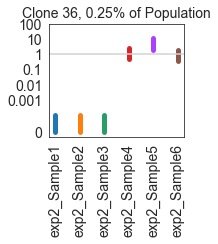

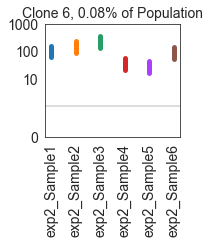

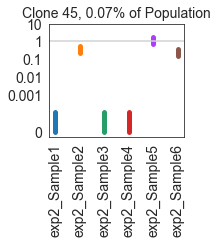

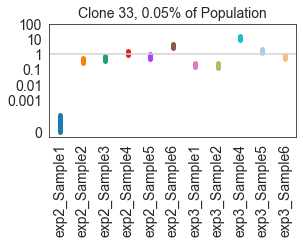

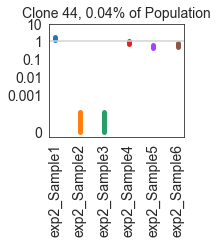

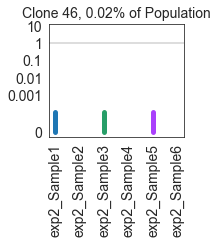

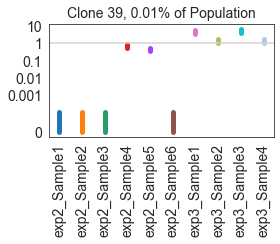

In [16]:
for clone in clones:
    gr_plot(clone)

In [17]:
np.sqrt(1000*0.0252*(1-0.0252))

4.956305075356036

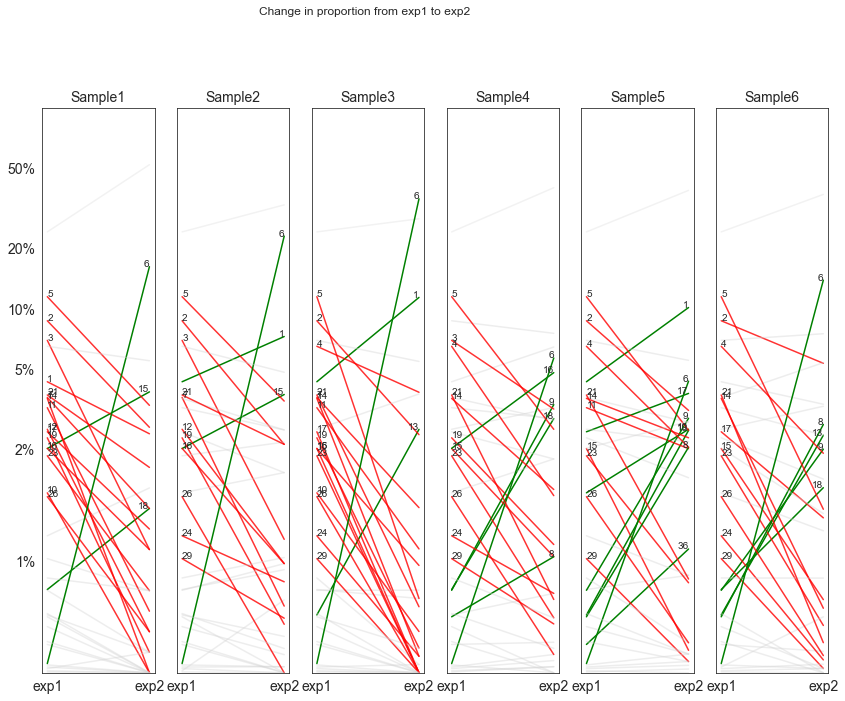

In [18]:
fig,ax = plt.subplots(1,6,figsize=(14,10), sharey=True)
plt.yscale('symlog')
for j,sample in enumerate(samples):
    ax_cur = ax[j]
    for clone in pop_df.index:
        y1 = 100*pop_df.loc[clone, 'exp1_perc']
        y2 = 100*pop_df.loc[clone, 'exp2_{}_perc'.format(sample)]
        if (y2 > (y1*1.5)) and (y2 > 1):
            color = 'green'
            alpha = 1
        elif (y2 < (y1/1.5)) and (y1 > 1):
            color = 'red'
            alpha = 0.8
        else:
            color = 'lightgray'
            alpha = 0.4
        if clone == 'non':
            color = 'gray'
            alpha=0.1
        ax_cur.plot([0,1], [y1,y2], label=clone,c=color, alpha=alpha, lw=1.5)
        if color == 'green':
            ax_cur.text(1.0,y2,clone, ha='right')
        if color == 'red':
            ax_cur.text(0.0,y1,clone, ha='left')
        ax_cur.set_xticks([0,1])
        ax_cur.set_xticklabels(['exp1','exp2'])
        ax_cur.set_yticks([1,2,5,10,20,50])
        ax_cur.set_yticklabels(['1%','2%','5%','10%','20%','50%'])
        ax_cur.set_ylim([0,100])
        ax_cur.set_title(sample)
plt.suptitle('Change in proportion from exp1 to exp2', y=1.05)
plt.show()